## -------------------------------------------------------------------
## PROJETO FINAL: MODELO DE REGRESSÃO LINEAR
## GRUPO INFNET "R"
## Data: 08/09/2025
## Descrição: Análise dos fatores que influenciam os custos médicos.
## -------------------------------------------------------------------

### 1ª ETAPA: CONFIGURAÇÃO DO AMBIENTE

In [562]:
### Instalar pacotes
suppressMessages(install.packages("tidyverse"))
suppressMessages(install.packages("corrplot"))
suppressMessages(install.packages("ggplot2"))

Warning message:
"o pacote 'tidyverse' está em uso e não será instalado"
Warning message:
"o pacote 'corrplot' está em uso e não será instalado"
Warning message:
"o pacote 'ggplot2' está em uso e não será instalado"


In [563]:
### Carregar os pacotes
library(tidyverse)
library(corrplot)
library(ggplot2)

### 2ª ETAPA: CARGA E VERIFICAÇÃO DOS DADOS

In [564]:
dados <- read.csv(".././data/insurance.csv")

In [565]:
# Verificar se os dados foram carregados corretamente
head(dados)
str(dados)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.900,0,yes,southwest,16884.924
2,18,male,33.770,1,no,southeast,1725.552
3,28,male,33.000,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.471
5,32,male,28.880,0,no,northwest,3866.855
6,31,female,25.740,0,no,southeast,3756.622


'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : chr  "female" "male" "male" "male" ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : chr  "yes" "no" "no" "no" ...
 $ region  : chr  "southwest" "southeast" "southeast" "northwest" ...
 $ charges : num  16885 1726 4449 21984 3867 ...


### 3ª ETAPA: LIMPEZA E PREPARAÇÃO

In [566]:
# Descreve a estrutura dos dados, e o primeiro ponto a se observar é a tipagem das colunas
# sex, smoker e region, que estão como chr, tornando impossível de se trabalhar com elas como
# colunas categóricas.

dados <- dados %>%
  mutate(
    sex = as.factor(sex),
    smoker = as.factor(smoker),
    region = as.factor(region)
  )

# Realiza-se então a conversão para o tipo factor e verifica-se a estrutura novamente.
str(dados)

'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : Factor w/ 2 levels "female","male": 1 2 2 2 2 1 1 1 2 1 ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : Factor w/ 2 levels "no","yes": 2 1 1 1 1 1 1 1 1 1 ...
 $ region  : Factor w/ 4 levels "northeast","northwest",..: 4 3 3 2 2 3 3 2 1 2 ...
 $ charges : num  16885 1726 4449 21984 3867 ...


In [567]:
colSums(is.na(dados))
# verificar valores faltantes (NA). O dataset está sem valores ausentes.

age      sex      bmi children   smoker   region  charges 
       0        0        0        0        0        0        0

In [568]:
duplicados <- sum(duplicated(dados))
print(paste("Número de linhas duplicadas encontradas:", duplicados))
# Identifica e exibe quantidade de linhas com valores duplicados.

[1] "Número de linhas duplicadas encontradas: 1"


In [569]:
if (duplicados > 0) {
  dados <- distinct(dados)
  print("Linha(s) duplicada(s) removida(s).")
}
#Verifica e remove valores duplicados.

[1] "Linha(s) duplicada(s) removida(s)."


## 4ª ETAPA: PRIMEIRA ANÁLISE

### ANÁLISE EXPLORATÓRIA

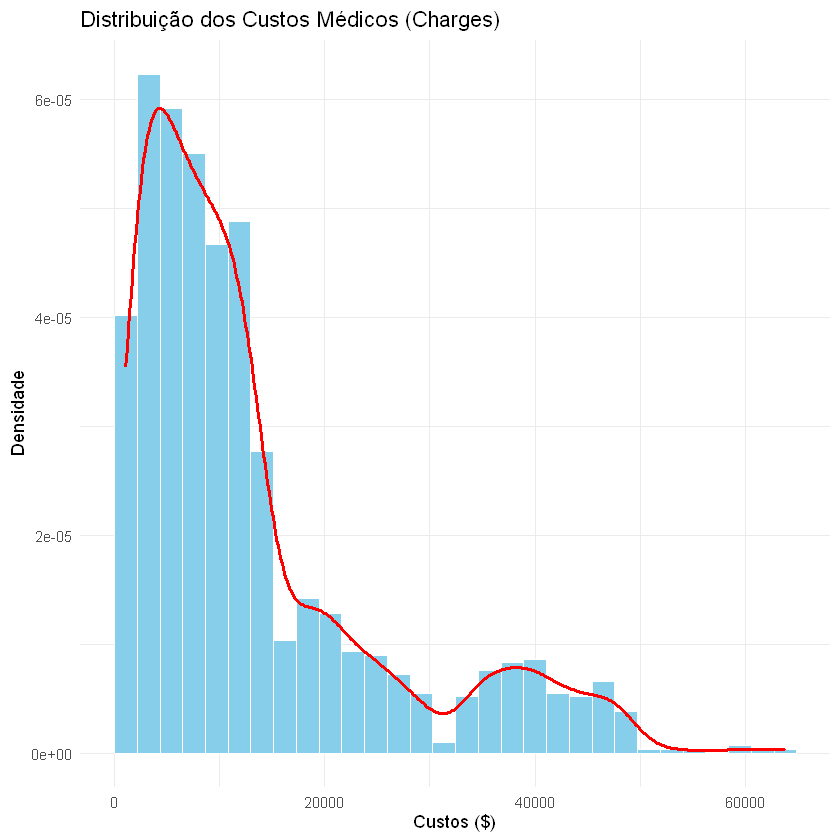

In [570]:
# a) Análise da Variável Dependente (Charges)
# Vamos criar um histograma para ver a distribuição dos custos.
ggplot(dados, aes(x = charges)) +
  geom_histogram(aes(y = ..density..), fill = "skyblue", color = "white", bins = 30) +
  geom_density(col = "red", size = 1) +
  labs(
    title = "Distribuição dos Custos Médicos (Charges)",
    x = "Custos ($)",
    y = "Densidade"
  ) +
  theme_minimal()

# O gráfico exibe a distribuição horizontal dos custos médicos e o quão pertinentes eles são.
# É possível identificar uma assimetria a direita, indicando maior frequência de custos à esquerda.
# Ou seja, os gastos mais frequentes são os que estão à esquerda, os menores horizontalmente.
# Isso aponta para o fato de que as pessoas possuem mais custos médicos baixos do que altos.


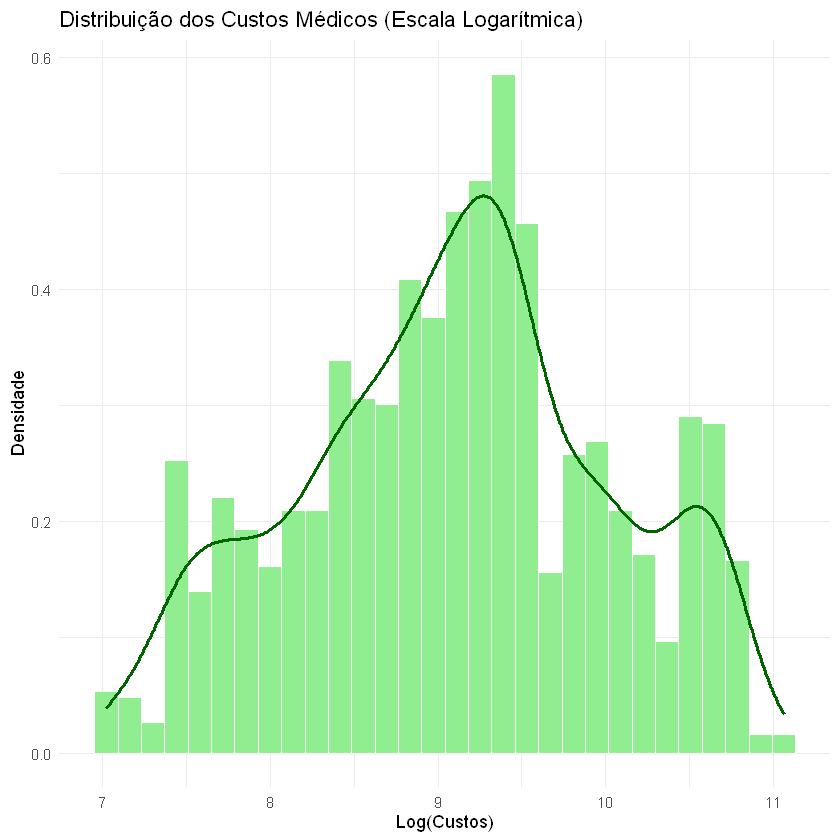

In [571]:
# b) Visualizando a transformação logarítmica
ggplot(dados, aes(x = log(charges))) +
  geom_histogram(aes(y = ..density..), fill = "lightgreen", color = "white", bins = 30) +
  geom_density(col = "darkgreen", size = 1) +
  labs(
    title = "Distribuição dos Custos Médicos (Escala Logarítmica)",
    x = "Log(Custos)",
    y = "Densidade"
  ) +
  theme_minimal()


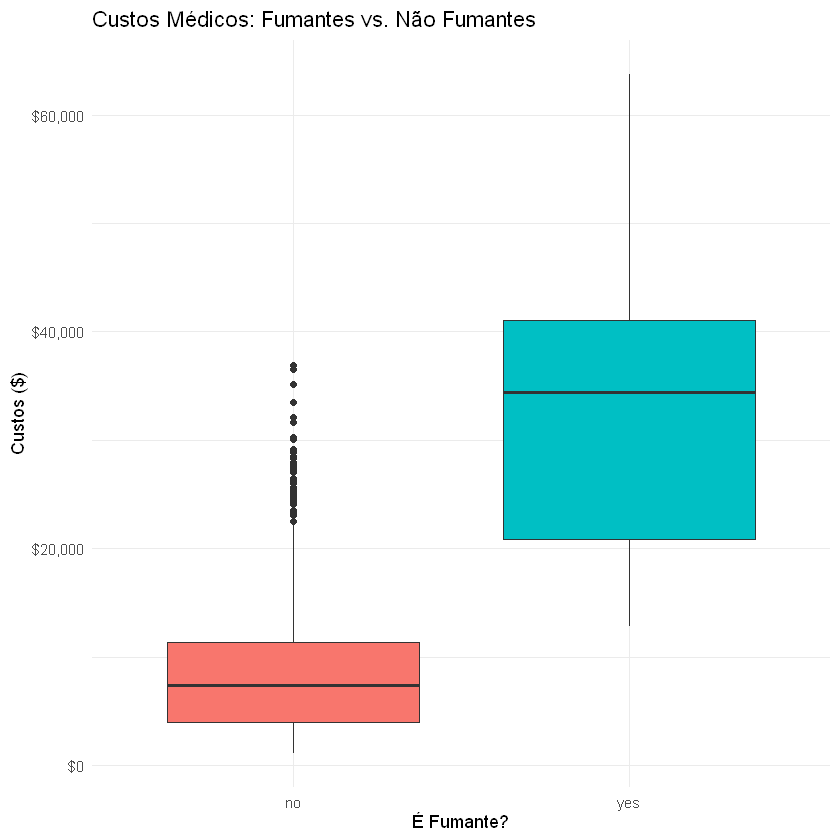

In [572]:
# c) Relação de Charges com Preditores Categóricos

# Charges vs. Smoker
ggplot(dados, aes(x = smoker, y = charges, fill = smoker)) +
  geom_boxplot(show.legend = FALSE) +
  labs(
    title = "Custos Médicos: Fumantes vs. Não Fumantes",
    x = "É Fumante?",
    y = "Custos ($)"
  ) +
  scale_y_continuous(labels = scales::dollar) + # Formata o eixo Y para dólar
  theme_minimal()

# Dada as conclusões do gráfico anterior, deve-se analisar o ponto central da distribuição horizontal verificada,
# Uma vez que ela é assimétrica e demostra haverem alguns outliers
# É questionável também o fato de não sabermos quem são os fumantes e não-fumantes nessa distribuição.
# A partir da mediana dos custos médicos entre fumantes e não fumantes, algo fica claro.
# Pessoas que fumam possuem gastos muito maiores do que pessoas que não fumam, com exceção de alguns outliers.
# Isso leva a entender que os fumantes se encaixam na parte assimétrica do gráfico anterior.

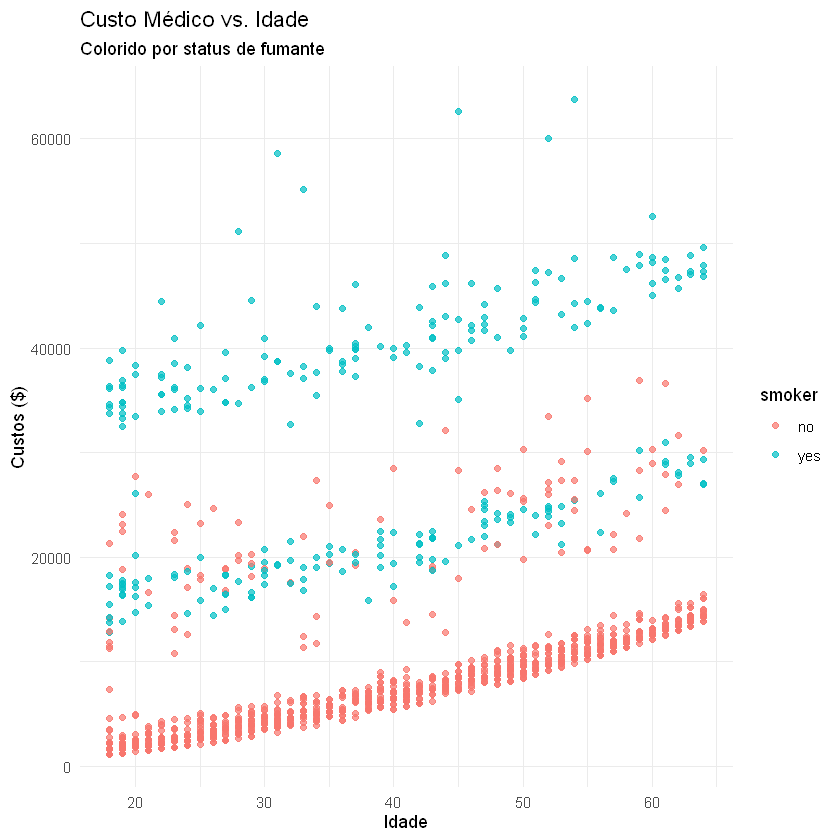

In [573]:
# d) Relação de Charges com Preditores Quantitativos

# Charges vs. Age (colorindo por smoker para mais insights)
ggplot(dados, aes(x = age, y = charges)) +
  geom_point(aes(color = smoker), alpha = 0.7) +
  labs(
    title = "Custo Médico vs. Idade",
    subtitle = "Colorido por status de fumante",
    x = "Idade",
    y = "Custos ($)"
  ) +
  theme_minimal()


### MODELAGEM - CONSTRUÇÃO DO MODELO

In [574]:
# Vamos construir nosso primeiro modelo usando os preditores que a Análise
# Exploratória sugeriu serem os mais importantes.
# Nossa variável dependente será log(charges) para satisfazer os pressupostos do modelo.

modelo_1 <- lm(log(charges) ~ age + bmi + smoker, data = dados)

In [575]:
# A função summary() nos dá um relatório completo sobre o nosso modelo.
# Este é o output mais importante de toda a sua análise!
summary(modelo_1)


Call:
lm(formula = log(charges) ~ age + bmi + smoker, data = dados)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22166 -0.21732 -0.03983  0.10344  2.07125 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.0761244  0.0715858   98.85  < 2e-16 ***
age         0.0350930  0.0009117   38.49  < 2e-16 ***
bmi         0.0107853  0.0020982    5.14 3.15e-07 ***
smokeryes   1.5451927  0.0315190   49.02  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.465 on 1333 degrees of freedom
Multiple R-squared:  0.7443,	Adjusted R-squared:  0.7438 
F-statistic:  1294 on 3 and 1333 DF,  p-value: < 2.2e-16


### DIAGNÓSTICO DO MODELO

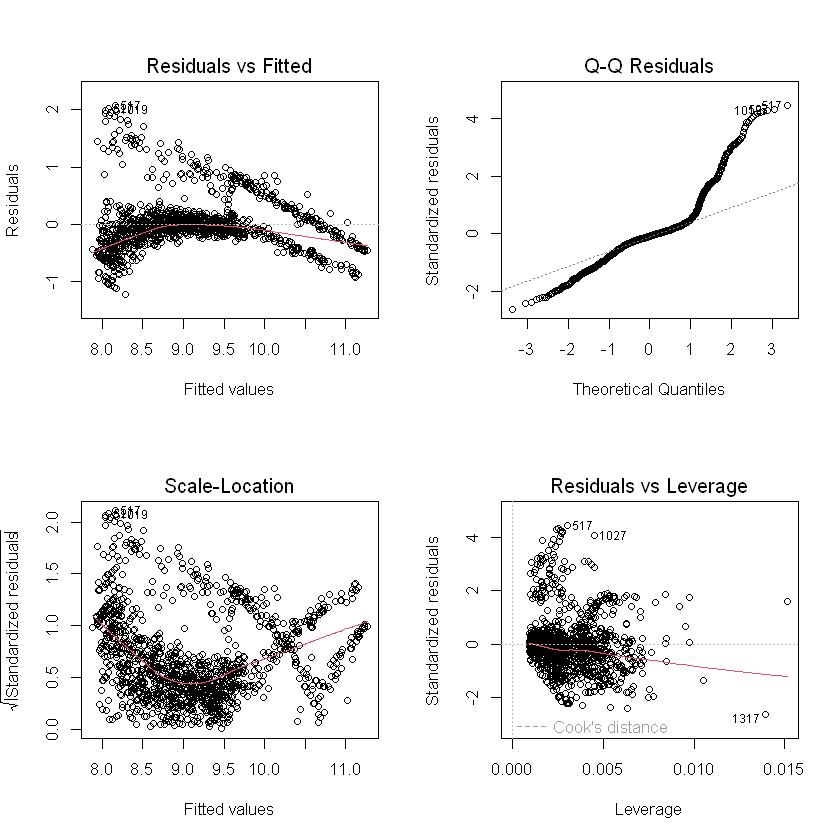

In [576]:
# A função plot() aplicada a um objeto 'lm' gera 4 gráficos de diagnóstico.
# Usamos par(mfrow = c(2, 2)) para arranjar os 4 gráficos em uma grade 2x2.

par(mfrow = c(2, 2))
plot(modelo_1)

# É uma boa prática resetar o layout gráfico para o padrão depois.
par(mfrow = c(1, 1))


## 5ª ETAPA: SEGUNDA ANÁLISE

### LIMPEZA E PREPARAÇÃO

In [577]:
dados_pt <- dados %>%
  rename(
    idade = age,
    sexo = sex,
    imc = bmi,
    filhos = children,
    fumante = smoker,
    regiao = region,
    custos = charges
  ) %>%
  mutate(
    eh_fumante = ifelse(fumante == "yes", 1, 0),
    sexo_masculino = ifelse(sexo == "male", 1, 0),
    regiao_norte = ifelse(grepl("north", regiao), 1, 0),
    regiao_leste = ifelse(grepl("east", regiao), 1, 0)
  )
dados_pt <- dados_pt %>%
  select_if(is.numeric)
head(dados_pt)
# Renomeia colunas para melhor organização e identificação de
# seus dados e ajusta as variáveis para o formato numérico.

,idade,imc,filhos,custos,eh_fumante,sexo_masculino,regiao_norte,regiao_leste
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19,27.900,0,16884.924,1,0,0,0
2,18,33.770,1,1725.552,0,1,0,1
3,28,33.000,3,4449.462,0,1,0,1
4,33,22.705,0,21984.471,0,1,1,0
5,32,28.880,0,3866.855,0,1,1,0
6,31,25.740,0,3756.622,0,0,0,1


### ANÁLISE EXPLORATÓRIA - ÊNFASE EM NÃO FUMANTES

In [578]:
# a) Análise Descritiva dos Dados

# A Média de 'charges' ($13.2k) é bem maior que a Mediana ($9.3k),
# indicando que custos muito altos de poucas pessoas influenciam o total.
# A base é bem balanceada em sexo e região, mas com muito mais não-fumantes.
summary(dados_pt)

     idade            imc            filhos          custos     
 Min.   :18.00   Min.   :15.96   Min.   :0.000   Min.   : 1122  
 1st Qu.:27.00   1st Qu.:26.29   1st Qu.:0.000   1st Qu.: 4746  
 Median :39.00   Median :30.40   Median :1.000   Median : 9386  
 Mean   :39.22   Mean   :30.66   Mean   :1.096   Mean   :13279  
 3rd Qu.:51.00   3rd Qu.:34.70   3rd Qu.:2.000   3rd Qu.:16658  
 Max.   :64.00   Max.   :53.13   Max.   :5.000   Max.   :63770  
   eh_fumante     sexo_masculino    regiao_norte     regiao_leste   
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :1.0000   Median :0.0000   Median :1.0000  
 Mean   :0.2049   Mean   :0.5049   Mean   :0.4847   Mean   :0.5146  
 3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  

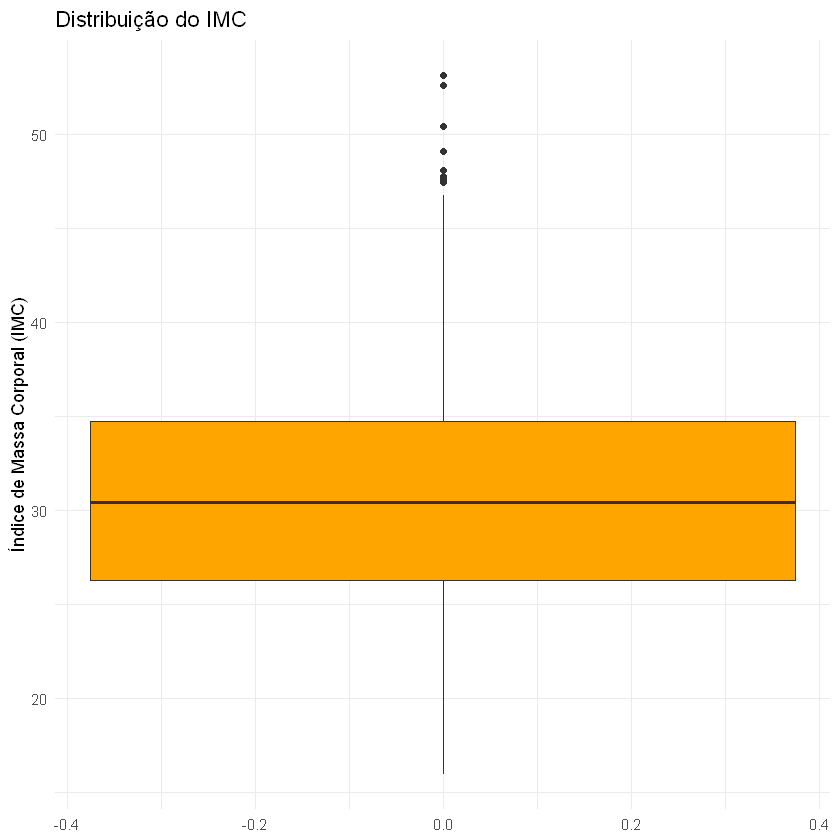

In [579]:
# b) Análise da Distribuição do IMC
# Boxplot para analisar a mediana, dispersão e outliers do IMC.
ggplot(dados_pt, aes(y = imc)) +
  geom_boxplot(fill = "orange") +
  labs(title = "Distribuição do IMC", y = "Índice de Massa Corporal (IMC)") +
  theme_minimal()
# Visualizando um boxplot que distribui a mediana do IMC das pessoas, é possível identificar algumas discrepâncias com
# IMC muito alto, ou seja, outliers. Essas pessoas podem de fato possuir esse IMC, portanto, não serão desconsideradas.
# Isso pode apontar para o fato de que algumas pessoas podem ter custos médicos altos não em decorrência do cigarro, mas talvez
# da obesidade, podendo possuir esse fato correlação com o hábito de fumar ou não.

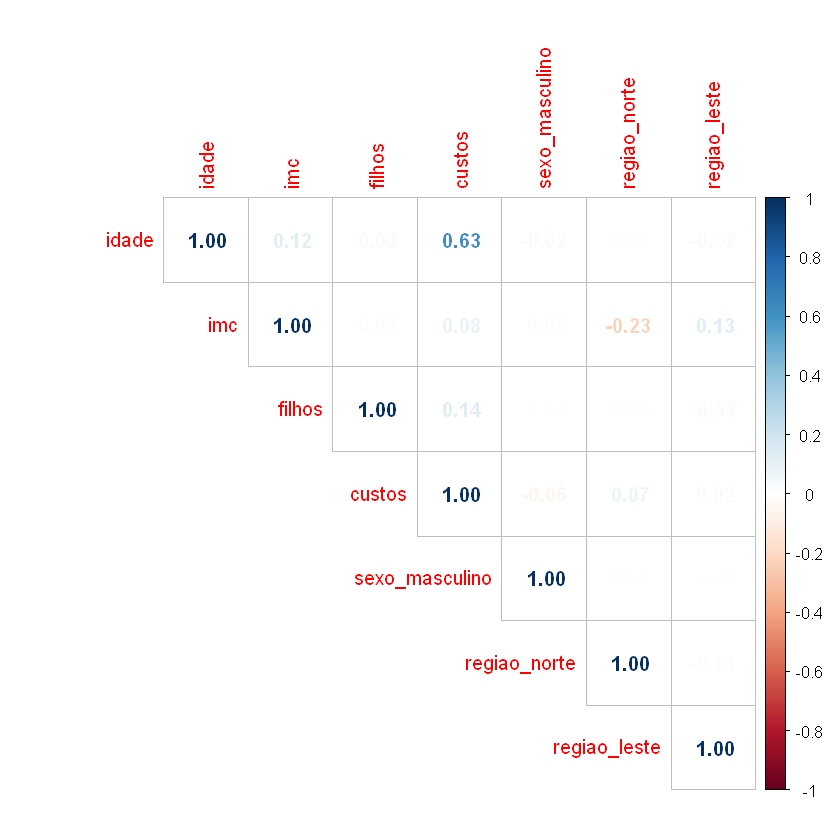

In [580]:
# c) Matriz de Correlação (Não Fumantes)
# Análise das relações lineares para o subgrupo de não fumantes.

nao_fumantes <- subset(dados_pt, eh_fumante == 0) %>% select(-eh_fumante)

matriz_cor <- cor(nao_fumantes)
corrplot(matriz_cor, method = "number", type = "upper")

# A correlação mostra que o IMC tende a ser maior nas regiões sul e leste.
# Entre não fumantes, a idade domina e o impacto do IMC é mínimo,
# sendo menos relevante que o número de filhos.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


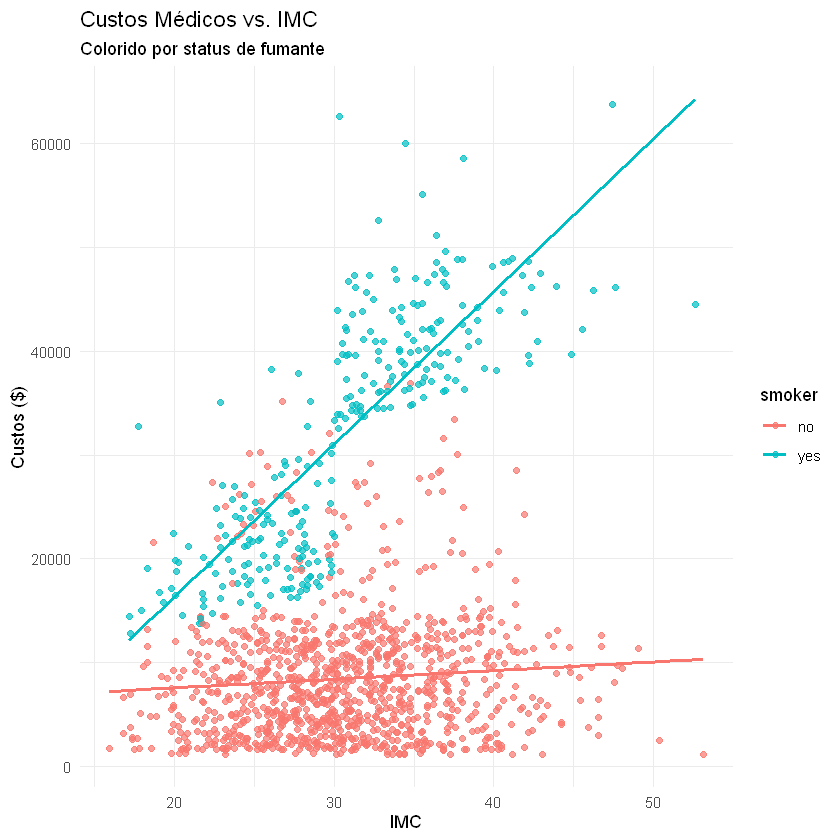

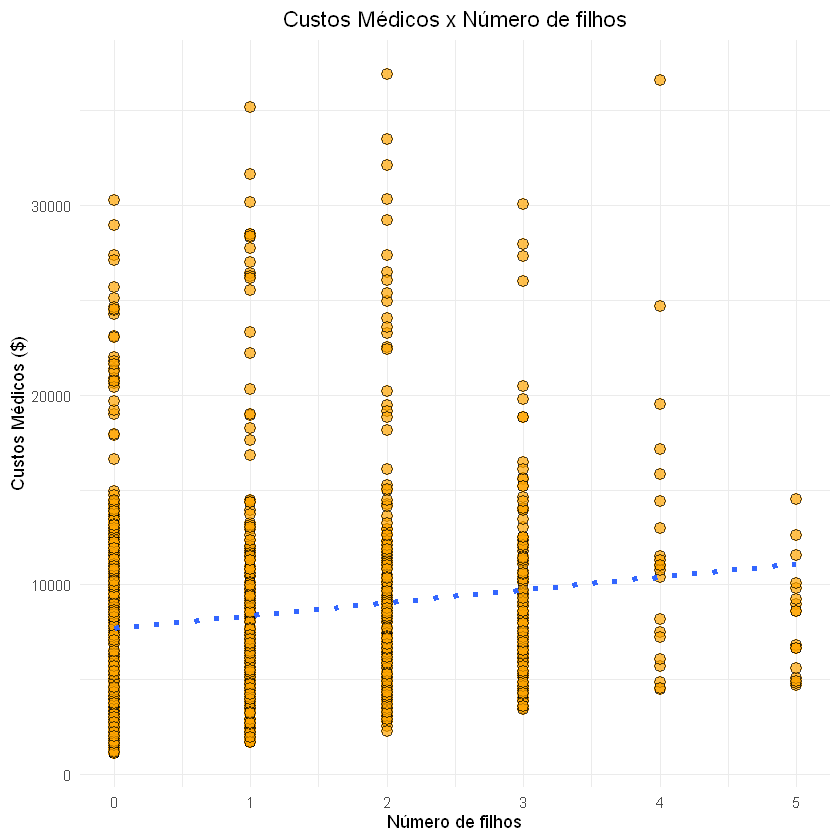

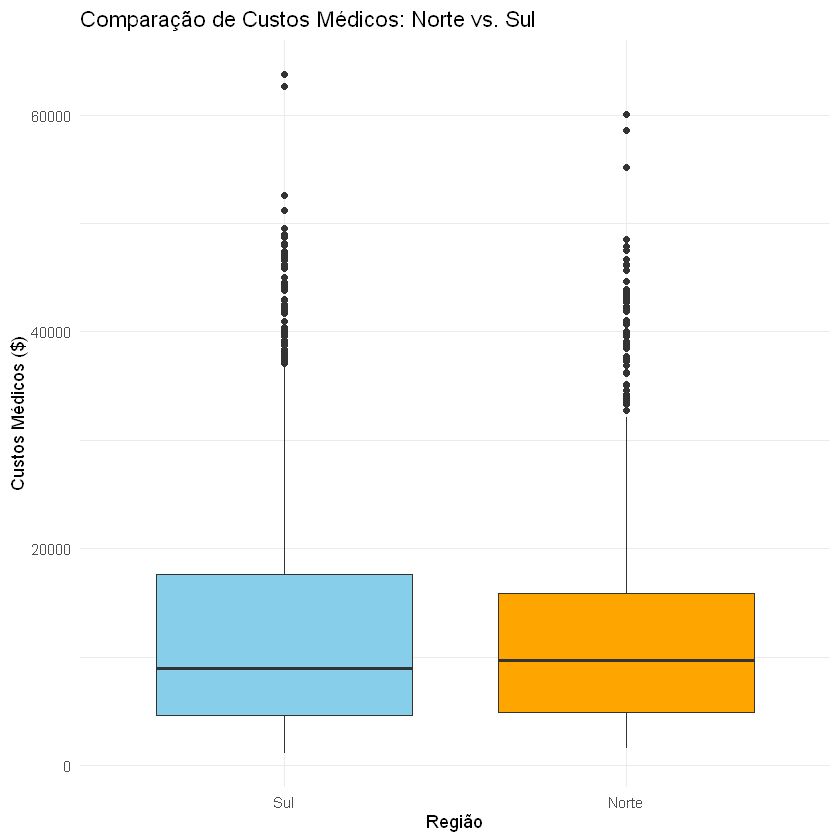

In [581]:
# d) Análise Gráfica das Relações com Custos

# Gráfico 1: Custo vs. IMC, comparando fumantes e não fumantes.
ggplot(dados, aes(x = bmi, y = charges, color = smoker)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(
    title = "Custos Médicos vs. IMC",
    subtitle = "Colorido por status de fumante",
    x = "IMC",
    y = "Custos ($)"
  ) +
  theme_minimal()

# Gráfico 2: Custo vs. Número de filhos para não fumantes.
ggplot(nao_fumantes, aes(x = filhos, y = custos)) +
  geom_point(alpha = 0.7,
             fill = "orange",
             color = "black",
             shape = 21, size = 3) +
  geom_smooth(method = "lm",
              se = FALSE,
              linetype = "dotted",
              linewidth = 1.5) +
  labs(
    title = "Custos Médicos x Número de filhos",
    x = "Número de filhos",
    y = "Custos Médicos ($)"
  ) +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))


# Gráfico 3: Comparação de Custos Médicos: Norte vs. Sul
ggplot(dados_pt, aes(x = factor(regiao_norte),
                     y = custos,
                     fill = factor(regiao_norte))) +
  geom_boxplot(show.legend = FALSE) +
  scale_x_discrete(labels = c("0" = "Sul", "1" = "Norte")) +
  scale_fill_manual(values = c("0" = "skyblue", "1" = "orange")) +
  labs(
    title = "Comparação de Custos Médicos: Norte vs. Sul",
    x = "Região",
    y = "Custos Médicos ($)"
  ) +
  theme_minimal()

### MODELAGEM - CONSTRUÇÃO DO MODELO

In [582]:
# Criação do modelo para não fumantes com base na análise exploratória.

modelo_nao_fumantes <- lm(log(custos) ~ idade + filhos + regiao_norte + I(idade^2), data = nao_fumantes)

In [ ]:
# Análise dos coeficientes e performance do modelo.
summary(modelo_nao_fumantes)

# O modelo para não fumantes é estatisticamente significativo (valor-p < 0.05)
# e explica 68.7% da variabilidade dos custos.
# Os custos crescem com o número de filhos e são maiores na região Norte.
# A idade tem um efeito curvo: os custos aumentam com a idade,
# porém de forma cada vez mais lenta.


Call:
lm(formula = log(custos) ~ idade + filhos + regiao_norte + I(idade^2), 
    data = nao_fumantes)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.60365 -0.16350 -0.08263 -0.01848  2.38090 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.549e+00  1.133e-01  57.826  < 2e-16 ***
idade         6.520e-02  6.359e-03  10.253  < 2e-16 ***
filhos        1.150e-01  1.102e-02  10.429  < 2e-16 ***
regiao_norte  1.350e-01  2.556e-02   5.281 1.56e-07 ***
I(idade^2)   -2.974e-04  7.934e-05  -3.749 0.000187 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4166 on 1058 degrees of freedom
Multiple R-squared:  0.6871,	Adjusted R-squared:  0.6859 
F-statistic: 580.8 on 4 and 1058 DF,  p-value: < 2.2e-16


### DIAGNÓSTICO DO MODELO

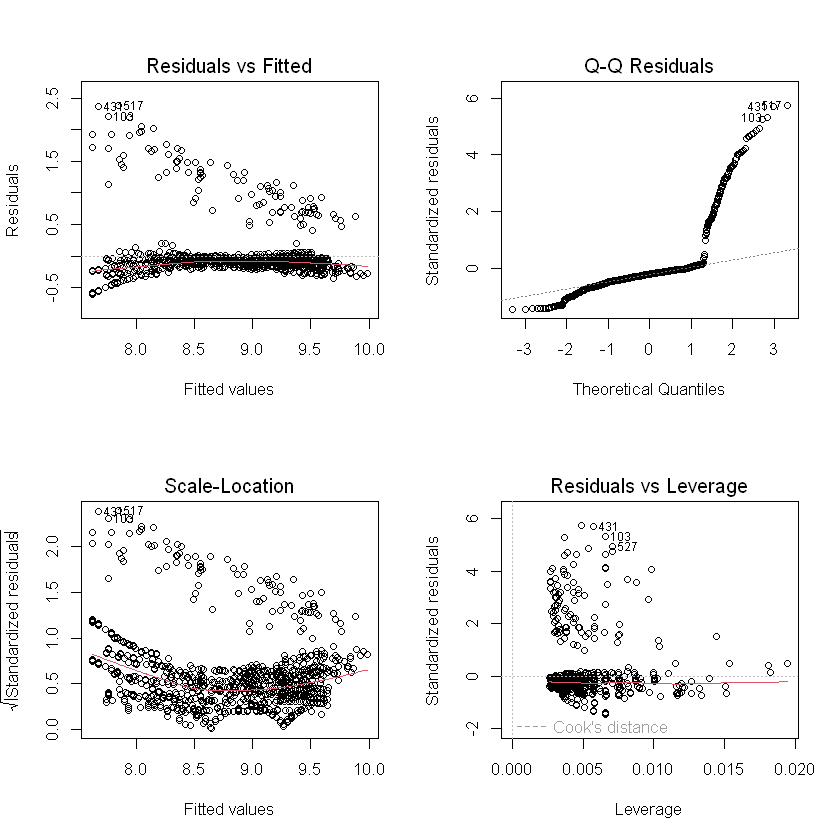

In [ ]:
par(mfrow = c(2, 2))
plot(modelo_nao_fumantes)
par(mfrow = c(1, 1))

# A linha de tendência bastante proxima de zero confirma a homocedasticidade do modelo.
# O gráfico Q-Q mostra que a distribuição dos resíduos não é perfeitamente normal, apresentando uma assimetria à direita
# causada por outliers (pacientes com custos muito altos) que o modelo não consegue prever adequadamente.
# Apesar disso, esses outliers não afetam o modelo de maneira significativa, pois nenhum ponto ultrapassa a distância de Cook.